In [1]:
# === IMPORTS ===

REP_DIR = "/home/graffc/extra/fire_prediction/"
SRC_DIR = REP_DIR + 'src/'
DATA_DIR = REP_DIR + 'data/'

# --- System imports
import numpy as np
import os as os
import datetime as dt
from collections import defaultdict
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# --- Package imports
import evaluation.evaluate_model as evm
import helper.loaders as load
import helper.multidata_wrapper as mdw
import visualization.plotting as vplt
import helper.date_util as du
import visualization.mapping as vmap
import evaluation.metrics as metrics

from models import grid_predictor as gp
from models import poisson_regression as pr
from models import active_ignition_grid as aig
from models import poisson_regression_grid as prg
from models import linear_regression_grid as lrg
from models import poisson_regression_zero_inflated as pzip
from models import bias_grid as bg
from models import autoregressive_grid as ag

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 15]

In [2]:
# Days to predict
T_K_MAX = 5
T_K_ARR = np.arange(1,T_K_MAX+1)

# Years to use
YEAR_START, YEAR_END = 2007, 2016
YEARS_ARR = np.arange(YEAR_START, YEAR_END+1)

# === DATA FILES ===
ignition_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_ignition_cube_modis_alaska_2007-2016.pkl')
detection_cube_src = os.path.join(DATA_DIR, 'interim/modis/fire_cube/fire_detection_cube_modis_alaska_2007-2016.pkl')
weather_proc_region_src = os.path.join(DATA_DIR, 'interim/gfs/weather_proc/4/weather_proc_gfs_4_alaska_2007-2016.pkl')
land_cover_src = os.path.join(DATA_DIR, 'interim/land_cover/land_cover_alaska.pkl')
        
# Build list of file names (based on t_k)
#integrated_cluster_df_fmt = 'processed/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_1400_%dk_alaska_2007-2016.pkl'
#integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_fmt = 'interim/integrated/fire_weather/fire_weather_integrated_gfs_4_modis_5km_10days_forwards_day_cents_1400_%dk_alaska_2007-2016.pkl'
integrated_cluster_df_src_list = map(lambda k: (k, os.path.join(DATA_DIR, integrated_cluster_df_fmt % k)), T_K_ARR)

In [3]:
# === DATA LOADING ===
X_ignition_c, Y_detection_c = evm.setup_ignition_data(ignition_cube_src, detection_cube_src)
weather_proc_region = load.load_pickle(weather_proc_region_src)
land_cover = load.load_pickle(land_cover_src)

X_active_df = {}
for t_k,f_src in integrated_cluster_df_src_list:
    X_active_df[t_k] = evm.setup_active_fire_data(f_src)
    
BOUNDING_BOX = weather_proc_region.bounding_box

In [4]:
# Non-grid baselines
def only_zero_model(covariates):
    model = aig.ActiveIgnitionGridModel(None, None)
    
    return model

def no_ignition_model_poisson(covariates):
    afm = gp.GridPredictorModel(pr.PoissonRegressionModel(covariates), BOUNDING_BOX)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def no_ignition_model_poisson_zip(covariates):
    afm = gp.GridPredictorModel(pzip.PoissonRegressionZeroInflatedModel(covariates), BOUNDING_BOX)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

In [5]:
# Grid baselines

def only_bias_grid_model(covariates):
    igm = bg.BiasGridModel()
    model = aig.ActiveIgnitionGridModel(None, igm)
    
    return model


def auto_grid_model(covariates):
    igm = ag.AutoregressiveGridModel()
    model = aig.ActiveIgnitionGridModel(None, igm)
    
    return model

In [6]:
# Grid models
def only_zero_grid_model(covariates):
    model = aig.ActiveIgnitionGridModel(None, None)
    
    return model

def no_ignition_grid_model_poisson(covariates):
    afm = prg.PoissonRegressionGridModel(covariates)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def no_ignition_grid_model_linear(covariates):
    afm = prg.LinearRegressionGridModel(covariates)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def active_only_grid_model_poisson(covariates, active='active', regularizer_weight=None):
    filter_func = lambda x: x[x[active]]
    pred_func = lambda x, y: y * x[active]
    
    afm = prg.PoissonRegressionGridModel(covariates, regularizer_weight, filter_func, pred_func)
    model = aig.ActiveIgnitionGridModel(afm, None)
    
    return model

def active_ig_grid_model_poisson(covariates):
    filter_func = lambda x: x[x.active]
    pred_func = lambda x, y: y * x.active
    
    afm = prg.PoissonRegressionGridModel(covariates, filter_func, pred_func)
    
    filter_func = lambda x: x[x.active==False]
    pred_func = lambda x, y: y * (x.active==False)
    ifm = prg.PoissonRegressionGridModel(covariates, filter_func, pred_func)
    
    model = aig.ActiveIgnitionGridModel(afm, ifm)
    
    return model

In [7]:
def print_results_table(results_list):
    metrics_ = [metrics.mean_absolute_error, metrics.root_mean_squared_error]
    for results,title in results_list:
        print title
        print '====================='
        for metric in metrics_:
            print metric.__name__
            table = []
            for k,v in results.iteritems():
                vals = map(lambda x: round(metric(*flat(x)),5), results[k])
                table.append([k]+vals)
            print tabulate.tabulate(table)

In [8]:
def build_y(y, t_k_arr, years=None):
    y_dict = {}
    for t_k in t_k_arr:
        # Shift y by t_k days
        shape = np.shape(y.values)[:2]+(t_k,)
        y_new = np.concatenate((y.values, np.zeros(shape)), axis=2)
        y_new = y_new[:,:,t_k:]
        
        # Convert y_new to an xarray dataset
        y_ds = xr.DataArray(y_new, coords={'time': pd.to_datetime(y.dates)}, dims=('y', 'x', 'time'))
        
        if years:
            y_ds = y_ds.sel(time=np.isin(y_ds.time.dt.year, years))
        
        y_dict[t_k] = y_ds
        
    return y_dict

def build_x_active(X, t_k_arr, years=None):
    X_dict = {}
    for t_k in t_k_arr:
        dates = pd.to_datetime(np.array(X[t_k]['date_local']))
        X_ds = xr.Dataset({'num_det': (('time'), X[t_k]['num_det']),
                           'temperature': (('time'), X[t_k]['temperature']),
                           'humidity': (('time'), X[t_k]['humidity']),
                           'wind': (('time'), X[t_k]['wind']),
                           'rain': (('time'), X[t_k]['rain']),
                           'lat_centroid': (('time'), X[t_k]['lat_centroid']),
                           'lon_centroid': (('time'), X[t_k]['lon_centroid']),
                           'num_det_target': (('time'), X[t_k]['num_det_target'])},
                          {'time': dates})
        
        if years:
            X_ds = X_ds.sel(time=np.isin(X_ds.time.dt.year, years))
        
        X_dict[t_k] = mdw.MultidataWrapper((X_ds,None))
    return X_dict

In [9]:
fill_n_days = 5

def fill_missing_value(data, date_ind):                                                    
    """
    Try to replace with closest prev day in range [1, fill_n_days].                                                

    If no non-nan value is found, replaces with mean of all values at the given lat/lon.                           
    """ 
    for day_offset in range(1,fill_n_days+1):                                                                 
        new_date_ind = date_ind - day_offset                                                                       

        if new_date_ind < 0:                                                                                       
            break                                                                                                  

        val = data[:, :, new_date_ind]                                                                 

        if not np.any(np.isnan(val)):                                                                                      
            return val                                                                                             

    return np.nanmean(data[:, :, :], axis=2)

def get_date_index(weather_data, target_datetime):
        date_ind = np.searchsorted(weather_data.dates, target_datetime, side='left')

        # Check if left or right element is closer
        if date_ind != 0:
            date_ind_left, date_ind_curr = date_ind-1, date_ind

            dist_left = abs((weather_data.dates[date_ind_left] - target_datetime).total_seconds())
            dist_curr = abs((weather_data.dates[date_ind_curr] - target_datetime).total_seconds())
            
            if dist_left < dist_curr:
                date_ind = date_ind_left

        return date_ind
    
def get_weather_variables(vals,weather_data, target_datetime, covariates):                                                             
    # Get date index
    date_ind = get_date_index(weather_data, target_datetime)                                                  

    #vals = []
    for key in covariates:                                                                           
        data = weather_data[key].values                                                                            
        val = data[:, :, date_ind]                                                                 

        if np.any(np.isnan(val)):
            val = fill_missing_value(data, date_ind)                                        

        #vals.append(val)                                                                                           
        vals[key].append(val)    

In [10]:
def create_cell_encoding(group_size, shape):
    data = []
    
    num_rows = int(np.ceil(shape[0]/(1.*group_size)))
    num_cols = int(np.ceil(shape[1]/(1.*group_size)))

    enc_all = np.zeros((num_rows,num_cols,shape[0],shape[1],shape[2]))
    
    # fill enc for each cell
    for i in range(shape[0]):
        for j in range(shape[1]):
            enc_all[int(i/group_size),int(j/group_size),i,j,:]=1
    
    # split into columns
    for i in range(num_rows):
        for j in range(num_cols):
            enc = enc_all[i,j]
            data.append(('cell_%d_%d'%(i,j),enc))
    return data
    
def build_x_grid(X, y, land_cover, t_k_arr, num_auto_memory=0, num_weather_mem=0, actives=[2,5,10], expon_decay=[.25, .5, .75], expon_decay_int=[5,10,15], years=None):
    X_dict = {}
    for t_k in t_k_arr:
             
        # Shift y by t_k days
        shape = np.shape(y.values)[:2]+(t_k,)
        y_new = np.concatenate((y.values, np.zeros(shape)), axis=2)
        y_new = y_new[:,:,t_k:]
            
        # Build grid of weather
        vals = defaultdict(list)
        for date in Y_detection_c.dates:
            time = 14
            date += du.INC_ONE_DAY * t_k # For row t, store weather(t+k)
            target_datetime = dt.datetime.combine(date, dt.time(time, 0, 0, tzinfo=du.TrulyLocalTzInfo(153, du.round_to_nearest_quarter_hour)))
            
            get_weather_variables(vals, X, target_datetime, ['temperature','humidity','wind','rain'])

        for k,v in vals.iteritems():
            vals[k] = np.rollaxis(np.array(v), 0, 3)  
        
        dates = pd.to_datetime(np.array(y.dates))
        X_ds = xr.Dataset({'num_det': (('y','x','time'), y.values),
                           'num_det_target': (('y', 'x', 'time'), y_new),
                           'active': (('y', 'x', 'time'), y.values!=0),
                           'temperature': (('y','x','time'), vals['temperature']),
                           'humidity': (('y','x','time'), vals['humidity']),
                           'wind': (('y','x','time'), vals['wind']),
                           'rain': (('y','x','time'), vals['rain'])},
                          {'time': dates})
        
        # Add land cover
        land_cover = np.array(land_cover, dtype=np.int8)
        num_land_cover_types = land_cover.shape[2]
        for i in range(num_land_cover_types):
            land_cover_t = land_cover[:,:,i,None].repeat(len(dates), axis=2)
            name = 'land_cover_%d' % i
            X_ds.update({name: (('y','x','time'), land_cover_t)})
        
        # Add autoregressive memory
        for i in range(1,num_auto_memory+1):
            shape = np.shape(y.values)[:2]+(i,)
            y_mem = np.concatenate((np.zeros(shape), y.values), axis=2)
            y_mem = y_mem[:,:,:-i]
            
            # Add one and apply log
            y_mem = np.log(y_mem+1)
            
            name = 'num_det_' + str(i)
            X_ds.update({name: (('y','x','time'), y_mem)})
            
        # Add weather memory (rain)
        rain_mean = np.mean(vals['rain'])
        for i in range(1,num_weather_mem+1):
            shape = np.shape(y.values)[:2]+(i,)
            x_mem = np.concatenate((np.zeros(shape)+rain_mean, vals['rain']), axis=2)
            x_mem = x_mem[:,:,:-i]
            
            name = 'rain_' + str(i)
            X_ds.update({name: (('y','x','time'), x_mem)})
            
        # Add weather memory (temp)
        rain_mean = np.mean(vals['temperature'])
        for i in range(1,num_weather_mem+1):
            shape = np.shape(y.values)[:2]+(i,)
            x_mem = np.concatenate((np.zeros(shape)+rain_mean, vals['temperature']), axis=2)
            x_mem = x_mem[:,:,:-i]
            
            name = 'temperature_' + str(i)
            X_ds.update({name: (('y','x','time'), x_mem)})
            
        # Add alternative active defns.
        for act in actives:
            shape = np.shape(y.values)[:2]+(act,)
            y_new = np.concatenate((np.zeros(shape), y.values), axis=2)
            is_act = y.values != 0
            for i in range(1,act):
                is_act = np.logical_or(is_act, y_new[:,:,(act-i):-i])
        
            name = 'active_' + str(act)
            X_ds.update({name: (('y','x','time'), is_act)})
            
        # Compute expon decay
        for num, decay in enumerate(expon_decay):
            for interval in expon_decay_int:
                vals = np.power(1-decay, range(1,interval))
                for cov in ['num_det', 'rain', 'temperature']:
                    new = np.zeros(np.shape(y.values))
                    for i in range(1, interval):
                        new += X_ds[cov + '_' + str(i)] * vals[i-1]
                    
                    name = cov + '_expon_' + str(num) + '_' + str(interval)
                    X_ds.update({name: (('y','x','time'), new)})
            
        if years:
            X_ds = X_ds.sel(time=np.isin(X_ds.time.dt.year, years))
                       
        X_dict[t_k] = mdw.MultidataWrapper((X_ds,X_ds))
        
        print 'T_k=%d' % t_k,
    print
    return X_dict

In [11]:
#YEARS_TRAIN = [2007]
#YEARS_TEST = [2007]
#T_K_ARR = np.arange(1,1+1)

YEARS_TRAIN = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
YEARS_TEST = [2007,2008,2009,2010, 2011, 2012, 2013, 2014, 2015, 2016]
T_K_ARR = np.arange(1,T_K_MAX+1)

y_grid_dict = build_y(Y_detection_c, T_K_ARR, YEARS_TRAIN)
X_active_dict = build_x_active(X_active_df, T_K_ARR, YEARS_TRAIN)
X_grid_dict = build_x_grid(weather_proc_region, Y_detection_c, land_cover, T_K_ARR, 15, 15, [2,5,10], [.25, .5, .75], [5,10,15], YEARS_TRAIN)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [ ]:
X_grid_dict[1][0]

In [12]:
# Add encoding pairs (for cell/region biases)
encoding_pairs = create_cell_encoding(11, X_grid_dict[1][0].num_det.shape)
for k,v in X_grid_dict.iteritems():
    for name,enc in encoding_pairs:
        v[0].update({name: (('y','x','time'), enc)})

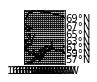

In [13]:
%%capture
plt.rcParams['figure.figsize'] = [1, 1]
bb = weather_proc_region.bounding_box
mp = vmap.make_map(bb)

In [14]:
plt.rcParams['figure.figsize'] = [15, 15]
water_mask = np.zeros((33,55))
for i,lat in enumerate(np.arange(55, 71+.5, .5)):
    for j,lon in enumerate(np.arange(-165, -138+.5, .5)):
        water_mask[i,j] = not mp.is_land(*mp(lon,lat))
        
water_mask = np.expand_dims(water_mask, axis=2)    
water_mask = np.tile(water_mask, (1,1,X_grid_dict[1][0].time.shape[0]))
        
for k,v in X_grid_dict.iteritems():
    v[0].update({'water_mask': (('y','x','time'), water_mask)})

In [21]:
param_dict = {#'None': [],
              #'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain']}

param_dict_grid = {#'None': [],
              #'Temp/Humid': ['temperature', 'humidity'],
              'All': ['temperature','humidity','wind','rain'],
              #'All + Water': ['temperature','humidity','wind','rain', 'water_mask'],
              #'All + Water (2)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,2)],
              #'All + Water (5)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,5)],
              #'All + Water (10)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,10)],
              #'All + Water (15)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,15)],
              #'All + Water (2,2)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,2)] + ['rain_' + str(i) for i in range(1,2)],
              #'All + Water (5,5)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,5)] + ['rain_' + str(i) for i in range(1,5)],     
              #'All + Water (10,10)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,10)] + ['rain_' + str(i) for i in range(1,10)],
              #'All + Water (15,15)': ['temperature','humidity','wind','rain', 'water_mask'] + ['num_det_' + str(i) for i in range(1,15)] + ['rain_' + str(i) for i in range(1,15)],}
              #'All + Biases': [n for n in X_grid_dict[1][0].data_vars if n != 'num_det_target']
            }             

In [19]:
# Test baselines
results_no_ig, models_no_ig = evm.evaluate_model_params(no_ignition_model_poisson, param_dict, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [42]:
results_auto_grid, models_auto_grid = evm.evaluate_model_params(auto_grid_model, {'None': []}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [228]:
results_no_ig_grid, models_no_ig_grid = evm.evaluate_model_params(no_ignition_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [ ]:
results_active_only_grid, models_active_only_grid = evm.evaluate_model_params(active_only_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

In [ ]:
results_active_ig_grid, models_active_ig_grid = evm.evaluate_model_params(active_ig_grid_model_poisson, param_dict_grid, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3


In [17]:
metrics_ = [metrics.root_mean_squared_error]
plt.rcParams['figure.figsize'] = [15, 8]

In [64]:
import pickle

def save(data, file_name):
    with open(file_name, 'wb') as fout:
        pickle.dump(data, fout)

### Baseline

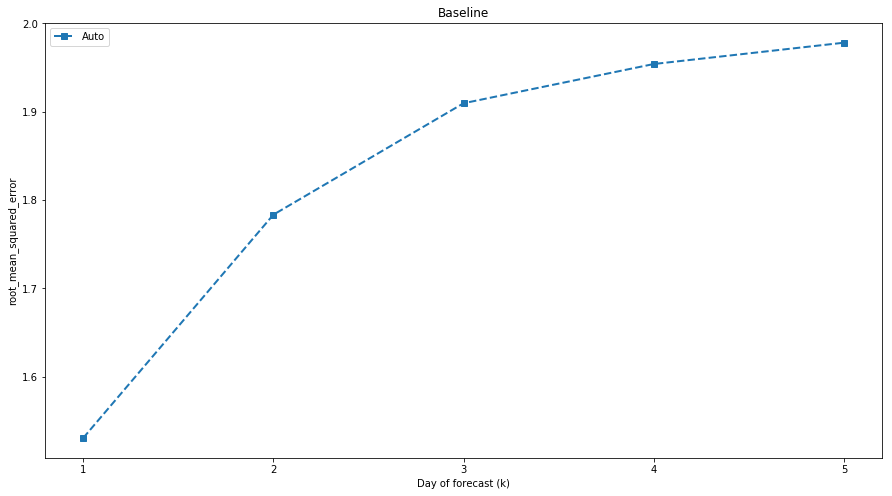

In [45]:
baseline = {'Auto': results_auto_grid[1]['None']}
grid_vs_cluster = vplt.plot_results_grid([(baseline, 'Baseline')], T_K_ARR, metrics_)

### Grid vs. Cluster

In [23]:
reload(gp)
results_no_ig_all, models_no_ig_all = evm.evaluate_model_params(no_ignition_model_poisson, {'All': ['temperature','humidity','wind','rain']}, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_all, models_active_only_grid_all = evm.evaluate_model_params(active_only_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


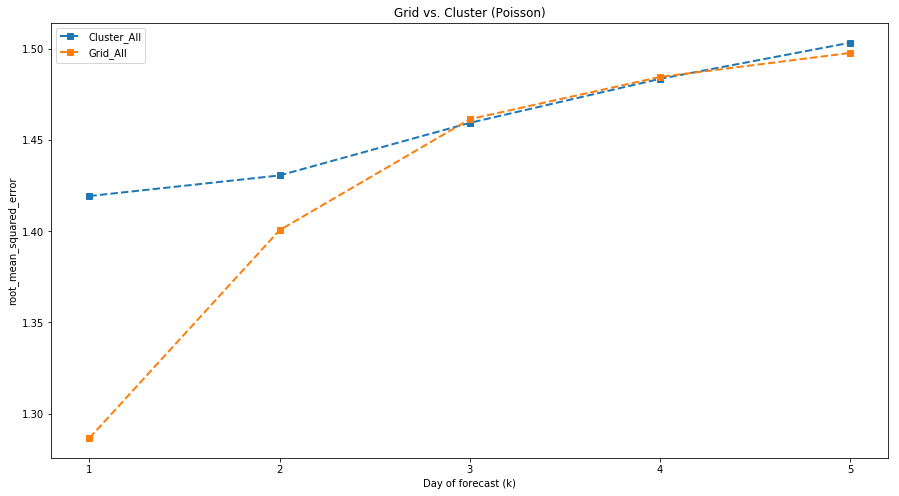

In [25]:
grid_vs_cluster_res = {'Cluster_All': results_no_ig_all[1]['All'], 'Grid_All': results_active_only_grid_all[1]['All']}
grid_vs_cluster = vplt.plot_results_grid([(grid_vs_cluster_res, 'Grid vs. Cluster (Poisson)')], T_K_ARR, metrics_)

In [65]:
models_no_ig_all['All'][0][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                 7111
Model:                            GLM   Df Residuals:                     7105
Model Family:                 Poisson   Df Model:                            5
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -66047.
Date:                Thu, 03 May 2018   Deviance:                   1.1696e+05
Time:                        12:09:23   Pearson chi2:                 2.40e+05
No. Iterations:                     7                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5950      0.009     69.090      0.000       0.578       0.612
np.log(num_det + 1)     0.6440      0.002    269.556      0.000       0.639       0.649
temperature             0.1276      0.006     20.309      0.000       0.115       0.140
humidity               -0.7558      0.008    -90.759      0.000      -0.772      -0.739
wind                    0.0311      0.004      8.859      0.000       0.024       0.038
rain                   -0.1765      0.010    -17.710      0.000      -0.196      -0.157
=======================================================================================
"""

In [15]:
results_no_ig_all, models_no_ig_all = evm.evaluate_model_params(no_ignition_model_poisson, {'All': ['temperature','humidity','wind','rain']}, X_active_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_all, models_active_only_grid_all = evm.evaluate_model_params(active_only_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [54]:
results_active_only_grid_none, models_active_only_grid_none = evm.evaluate_model_params(active_only_grid_model_poisson, {'Temp/Humid' : ['temperature', 'humidity']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [30]:
results_active_only_grid_all_act2, models_active_only_grid_none = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2'), {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_all_act5, models_active_only_grid_none = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_5'), {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


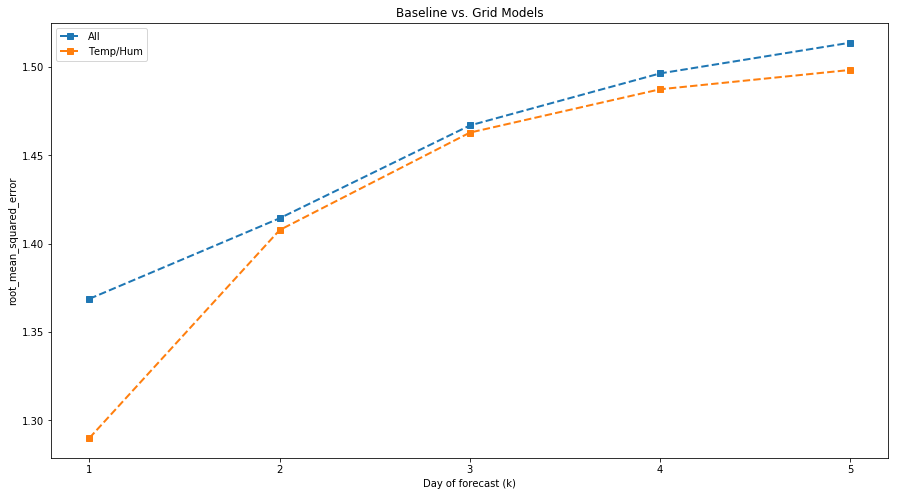

In [66]:
grid_vs_cluster_res = {'Temp/Hum': results_active_only_grid_none[1]['Temp/Humid'], 'All': results_no_ig_all[1]['All']}

grid_vs_cluster = vplt.plot_results_grid([(grid_vs_cluster_res, 'Baseline vs. Grid Models')], T_K_ARR, metrics_)

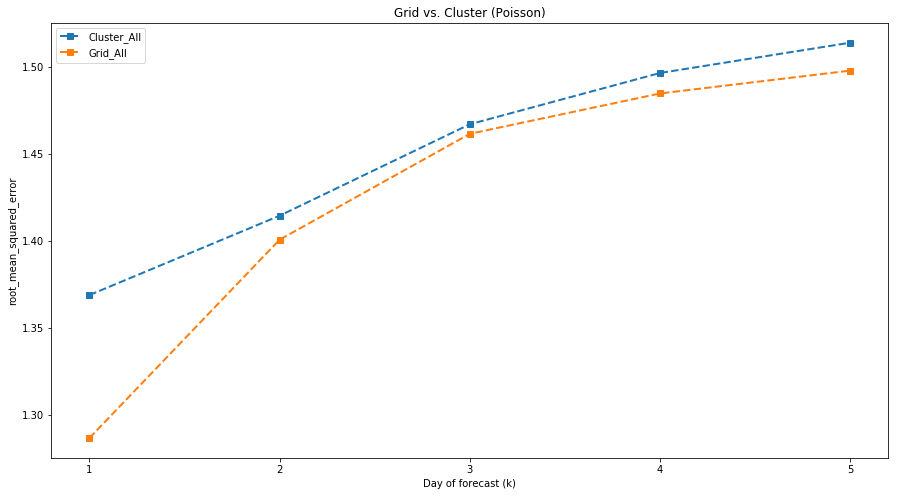

In [18]:
grid_vs_cluster_res = {'Cluster_All': results_no_ig_all[1]['All'], 'Grid_All': results_active_only_grid_all[1]['All']}
grid_vs_cluster = vplt.plot_results_grid([(grid_vs_cluster_res, 'Grid vs. Cluster (Poisson)')], T_K_ARR, metrics_)

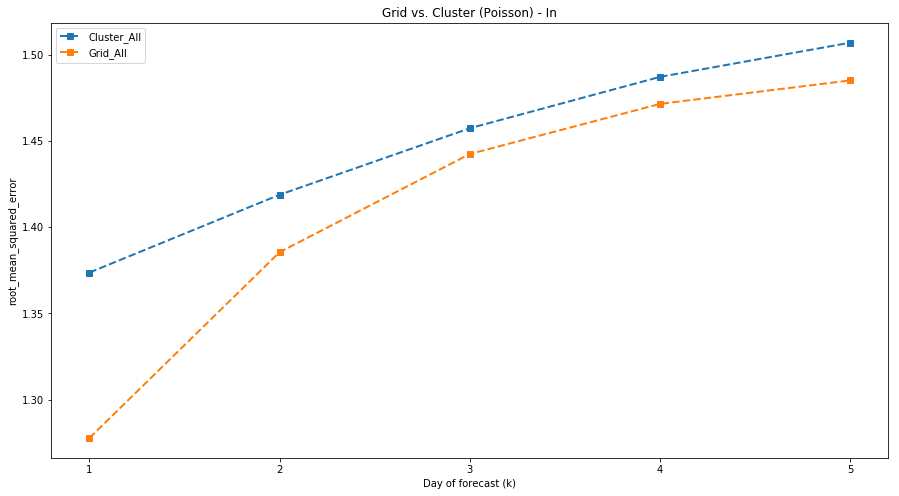

In [19]:
grid_vs_cluster_res = {'Cluster_All': results_no_ig_all[0]['All'], 'Grid_All': results_active_only_grid_all[0]['All']}
grid_vs_cluster = vplt.plot_results_grid([(grid_vs_cluster_res, 'Grid vs. Cluster (Poisson) - In')], T_K_ARR, metrics_)

### Unified vs. Separated

In [ ]:
results_no_ig_grid_all, models_no_ig_grid_all = evm.evaluate_model_params(no_ignition_grid_model_poisson, {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

In [ ]:
results_active_ig_grid_all, models_active_ig_grid_all = evm.evaluate_model_params(active_ig_grid_model_poisson,
                    {'All' : ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

In [ ]:
uni_vs_sep_res = {'Unified_All': results_no_ig_grid_all[1]['All'],
                  'Separated_All': results_active_ig_grid_all[1]['All'],
                  'Active-Only_All': results_active_ig_grid_all[1]['All']}
uni_vs_sep = vplt.plot_results_grid([(uni_vs_sep_res, 'Unified vs. Separated vs. Active-Only (Poisson)')], T_K_ARR, metrics_)

### Adding Memory (Learned Weights)

In [34]:
params_mem_5 = ['temperature','humidity','wind','rain'] + ['num_det_' + str(i) for i in range(1,5)] + ['rain_' + str(i) for i in range(1,5)] + ['temperature_' + str(i) for i in range(1,5)]
params_mem_10 = ['temperature','humidity','wind','rain'] + ['num_det_' + str(i) for i in range(1,10)] + ['rain_' + str(i) for i in range(1,10)] + ['temperature_' + str(i) for i in range(1,10)]
param_dict_mem = {'All + Mem (5)': params_mem_5, 'All + Mem (10)': params_mem_10}
results_active_only_grid_all_mem, models_active_only_grid_all_mem = evm.evaluate_model_params(active_only_grid_model_poisson, param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


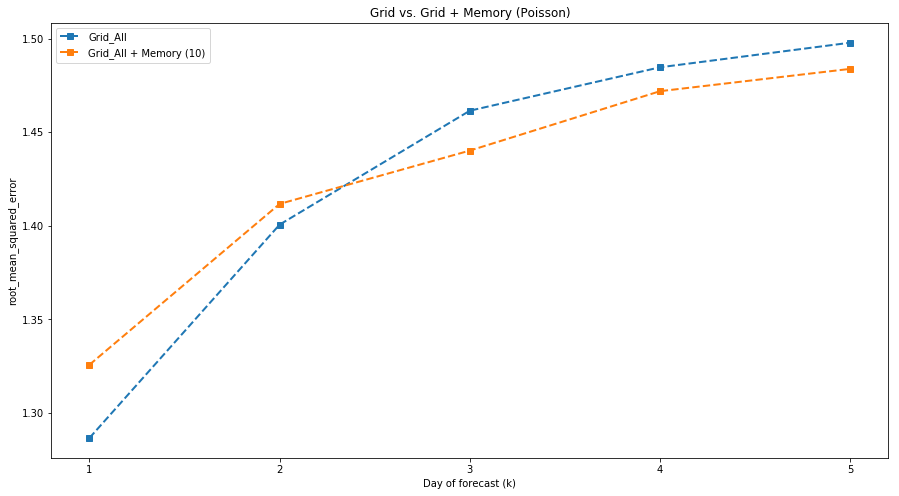

In [85]:
adding_mem_res = {'Grid_All': results_active_only_grid_all[1]['All'],
                  #'Grid_All + Memory (5)': results_active_only_grid_all_mem[1]['All + Mem (5)'],
                  'Grid_All + Memory (10)': results_active_only_grid_all_mem[1]['All + Mem (10)']}
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid vs. Grid + Memory (Poisson)')], T_K_ARR, metrics_)

### Adding Memory (Learned Weights) - Changing Active

In [81]:
results_active_only_grid_all_act_2, models_active_only_grid_all_act_2 = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2'), {'All': ['temperature','humidity','wind','rain']}, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [74]:
results_active_only_grid_all_mem_act_2, models_active_only_grid_all_mem = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2'), param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [59]:
results_active_only_grid_all_mem_act_5, models_active_only_grid_all_mem = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_5'), param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_all_mem_act_10, models_active_only_grid_all_mem = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_10'), param_dict_mem, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


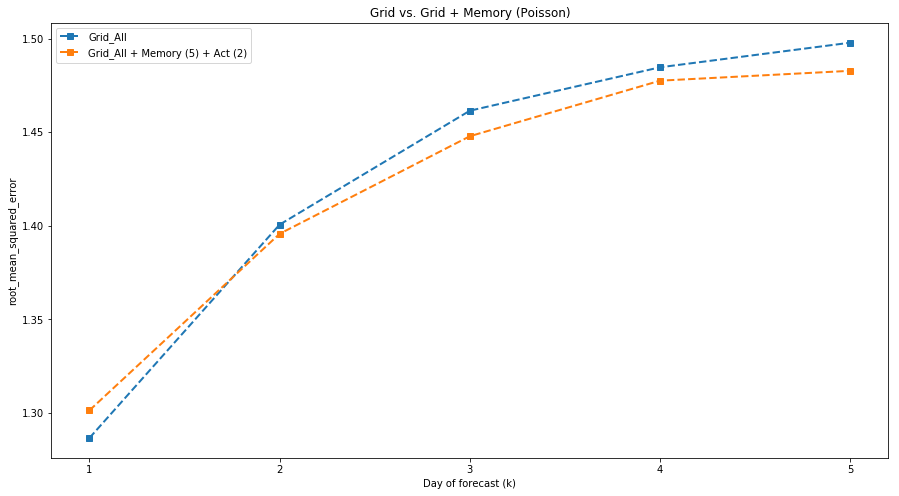

In [118]:
adding_mem_res = {'Grid_All': results_active_only_grid_all[1]['All'],
                  'Grid_All + Memory (5) + Act (2)': results_active_only_grid_all_mem_act_2[1]['All + Mem (5)'],
                  #'Grid_All + Act (2)': results_active_only_grid_all_act_2[1]['All'],
                  #'Grid_All + Memory (10) + Act (2)': results_active_only_grid_all_mem_act_2[1]['All + Mem (10)'],
                  #'Grid_All + Memory (5) + Act (5)': results_active_only_grid_all_mem_act_5[1]['All + Mem (5)'],
                  #'Grid_All + Memory (10) + Act (5)': results_active_only_grid_all_mem_act_5[1]['All + Mem (10)'],
                  #'Grid_All + Memory (5) + Act(10)': results_active_only_grid_all_mem_act_10[1]['All + Mem (5)'],
                  #'Grid_All + Memory (10) + Act(10)': results_active_only_grid_all_mem_act_10[1]['All + Mem (10)']
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid vs. Grid + Memory (Poisson)')], T_K_ARR, metrics_)

### Adding Memory (Expon. Decay)

In [36]:
params_dict_mem_expon = {}
for num,expon in enumerate([.25]):
    for expon_int in [10]:
        key = 'All + Expon Mem (%.2f, %d)' % (expon, expon_int)
        suffix = '_expon_%d_%d' % (num,expon_int)
        params_dict_mem_expon[key] = ['temperature','humidity','wind','rain'] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix] 

results_active_only_grid_all_mem_expon, models_active_only_grid_all_mem_expon = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2'), params_dict_mem_expon, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)


T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


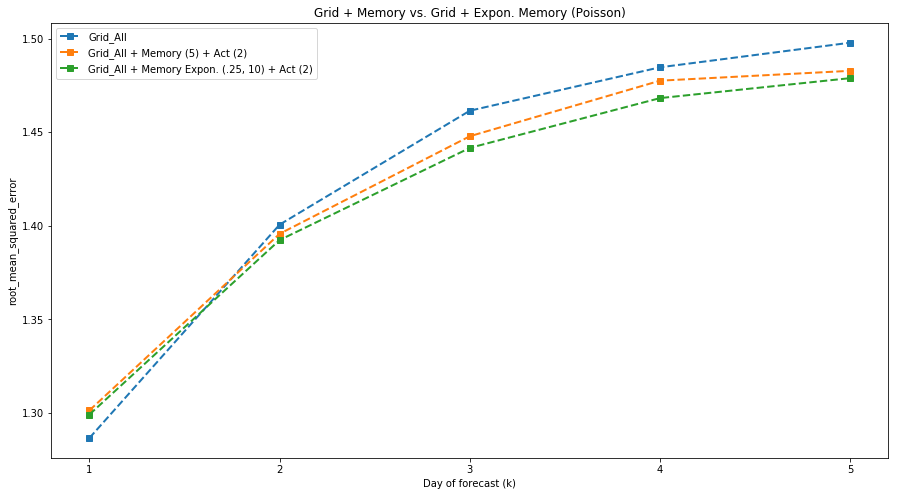

In [109]:
adding_mem_res = {#'Grid_All': results_active_only_grid_all[1]['All'],
                  #'Grid_All + Memory (5) + Act (2)': results_active_only_grid_all_mem_act_2[1]['All + Mem (5)'],
                  #'Grid_All + Expon. Memory (.25, 5) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 5)'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)'],
                  #'Grid_All + Expon. Memory (.5, 5) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.50, 5)'],
                  #'Grid_All + Expon. Memory (.5, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.50, 10)'],
                  #'Grid_All + Expon. Memory (.75, 5) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.75, 5)'],
                  #'Grid_All + Expon. Memory (.75, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.75, 10)'],
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Memory vs. Grid + Expon. Memory (Poisson)')], T_K_ARR, metrics_)

### Adding Ground Cover Type

In [28]:
suffix = '_expon_%d_%d' % (0,10)
params = ['temperature','humidity','wind','rain'] + ['land_cover_%d' % i for i in range(0,land_cover.shape[2])] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix]
params_dict_land = {'All + Memory Expon. (.25,10) + Act (2) + Land': params}
results_active_only_grid_land, models_active_only_grid_land = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2'), params_dict_land, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


In [32]:
suffix = '_expon_%d_%d' % (0,10)
params = ['temperature','humidity','wind','rain'] + ['land_cover_%d' % i for i in range(0,land_cover.shape[2])] + ['water_mask']
params_dict = {'All + Land': params}
results_active_only_grid_land_only, models_active_only_grid_land_only = evm.evaluate_model_params(active_only_grid_model_poisson, params_dict, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


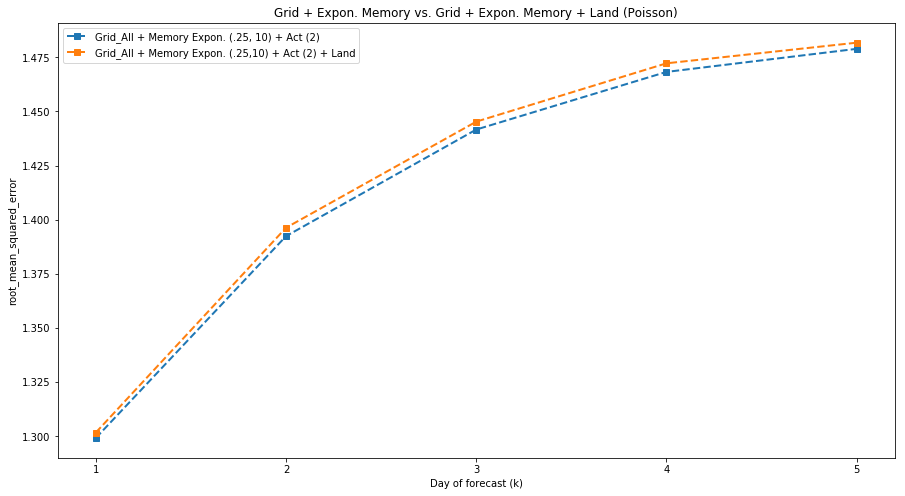

In [142]:
adding_mem_res = {#'Grid_All': results_active_only_grid_all[1]['All'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)'],
                  'Grid_All + Memory Expon. (.25,10) + Act (2) + Land': results_active_only_grid_land[1]['All + Memory Expon. (.25,10) + Act (2) + Land']
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Expon. Memory vs. Grid + Expon. Memory + Land (Poisson)')], T_K_ARR, metrics_)

In [47]:
models_active_only_grid_land['All + Memory Expon. (.25,10) + Act (2) + Land'][0][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                 9131
Model:                            GLM   Df Residuals:                     9109
Model Family:                 Poisson   Df Model:                           21
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -75530.
Date:                Fri, 20 Apr 2018   Deviance:                   1.3337e+05
Time:                        15:23:39   Pearson chi2:                 2.10e+05
No. Iterations:                    24                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.2699    319.335     -0.001      0.999    -626.154     625.614
np.log(num_det + 1)        0.6008      0.003    180.661      0.000       0.594       0.607
temperature                0.0103      0.001      7.885      0.000       0.008       0.013
humidity                  -0.0160      0.000    -46.286      0.000      -0.017      -0.015
wind                      -0.1448      0.003    -45.135      0.000      -0.151      -0.138
rain                      -0.0362      0.003    -12.526      0.000      -0.042      -0.031
land_cover_0              -0.0154      3.193     -0.005      0.996      -6.274       6.243
land_cover_1              -0.0110      3.193     -0.003      0.997      -6.270       6.248
land_cover_2            -2.83e-09   3.99e-06     -0.001      0.999   -7.83e-06    7.82e-06
land_cover_3             -22.5961   3.18e+04     -0.001      0.999   -6.24e+04    6.24e+04
land_cover_4              -0.1321      3.194     -0.041      0.967      -6.392       6.128
land_cover_5              -0.0199      3.193     -0.006      0.995      -6.279       6.239
land_cover_6            1.794e-08   2.53e-05      0.001      0.999   -4.95e-05    4.95e-05
land_cover_7              -0.0131      3.193     -0.004      0.997      -6.272       6.246
land_cover_8              -0.0122      3.193     -0.004      0.997      -6.271       6.247
land_cover_9              -0.0483      3.193     -0.015      0.988      -6.307       6.211
land_cover_10             -0.0119      3.193     -0.004      0.997      -6.271       6.247
land_cover_11             -0.1881      3.194     -0.059      0.953      -6.447       6.071
land_cover_12          -1.374e-11   2.82e-08     -0.000      1.000   -5.52e-08    5.52e-08
land_cover_13             -3.9107   3001.896     -0.001      0.999   -5887.519    5879.698
land_cover_14             -0.0671      3.194     -0.021      0.983      -6.326       6.192
land_cover_15             -0.0217      3.193     -0.007      0.995      -6.281       6.237
land_cover_16              0.0578      3.193      0.018      0.986      -6.201       6.317
num_det_expon_0_10         0.0397      0.001     27.720      0.000       0.037       0.042
rain_expon_0_10            0.0121      0.001      9.844      0.000       0.010       0.014
temperature_expon_0_10     0.0006      0.001      1.100      0.271      -0.000       0.002
==========================================================================================
"""

### Regularization

In [ ]:
suffix = '_expon_%d_%d' % (0,10)
params_expon_reg = ['temperature','humidity','wind','rain'] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix]
params_mem_10_reg = ['temperature','humidity','wind','rain'] + ['num_det_' + str(i) for i in range(1,10)] + ['rain_' + str(i) for i in range(1,10)] + ['temperature_' + str(i) for i in range(1,10)]
params_dict_reg = {'All + Memory Expon. (.25,10) + Act (2)': params_expon_reg,
                   'All + Memory (10) + Act (2)': params_mem_10_reg}
results_active_only_grid_reg_0, models_active_only_grid_reg_0 = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2',.01), params_dict_reg, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_reg_1, models_active_only_grid_reg_1 = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2',.1), params_dict_reg, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)
results_active_only_grid_reg_3, models_active_only_grid_reg_3 = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2',.5), params_dict_reg, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

 T_k=1 T_k=2 T_k=3 T_k=4 T_k=5
T_k=1 T_k=2 T_k=3 T_k=4

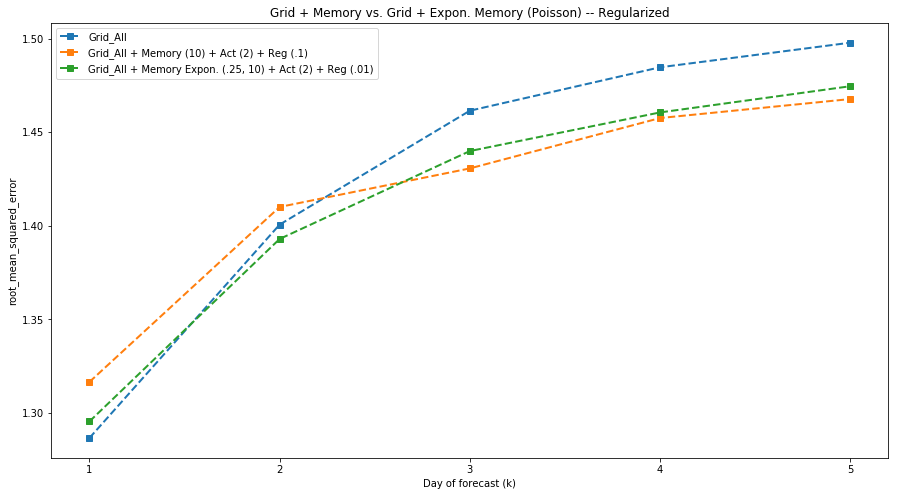

In [156]:
adding_mem_res = {'Grid_All': results_active_only_grid_all[1]['All'],
                  
                  #'Grid_All + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)'],
                  #'Grid_All + Memory (10)': results_active_only_grid_all_mem[1]['All + Mem (10)'],
                  
                  'Grid_All + Memory Expon. (.25, 10) + Act (2) + Reg (.01)': results_active_only_grid_reg_0[1]['All + Memory Expon. (.25,10) + Act (2)'],
                  #'Grid_All + Memory (10) + Act (2) + Reg (.01)': results_active_only_grid_reg_0[1]['All + Memory (10) + Act (2)'],
                  #'Grid_All + Memory Expon. (.25, 10) + Act (2) + Reg (.1)': results_active_only_grid_reg_1[1]['All + Memory Expon. (.25,10) + Act (2)'],
                  'Grid_All + Memory (10) + Act (2) + Reg (.1)': results_active_only_grid_reg_1[1]['All + Memory (10) + Act (2)'],
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Memory vs. Grid + Expon. Memory (Poisson) -- Regularized')], T_K_ARR, metrics_)

In [30]:
suffix = '_expon_%d_%d' % (0,10)
params = ['temperature','humidity','wind','rain'] + ['land_cover_10'] + ['num_det' + suffix, 'rain' + suffix, 'temperature' + suffix]
params_dict_land = {'All + Memory Expon. (.25,10) + Act (2) + Land': params}
results_active_only_grid_land_grass, models_active_only_grid_land = evm.evaluate_model_params(lambda x: active_only_grid_model_poisson(x,'active_2'), params_dict_land, X_grid_dict, y_grid_dict, YEARS_TEST, T_K_ARR)

T_k=1 T_k=2 T_k=3 T_k=4 T_k=5


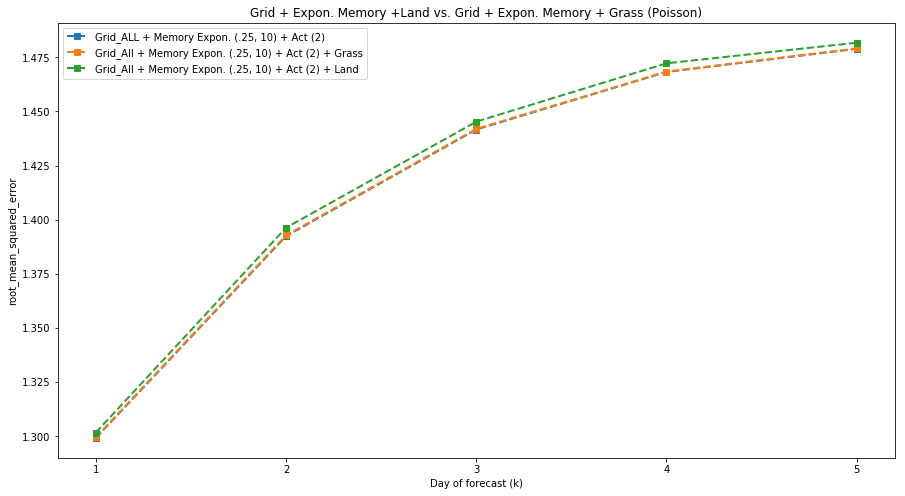

In [51]:
adding_mem_res = {#'Grid_All': results_active_only_grid_all[1]['All'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2) + Land': results_active_only_grid_land[1]['All + Memory Expon. (.25,10) + Act (2) + Land'],
                  'Grid_All + Memory Expon. (.25, 10) + Act (2) + Grass': results_active_only_grid_land_grass[1]['All + Memory Expon. (.25,10) + Act (2) + Land'],
                  'Grid_ALL + Memory Expon. (.25, 10) + Act (2)': results_active_only_grid_all_mem_expon[1]['All + Expon Mem (0.25, 10)']
                 }
adding_mem = vplt.plot_results_grid([(adding_mem_res, 'Grid + Expon. Memory +Land vs. Grid + Expon. Memory + Grass (Poisson)')], T_K_ARR, metrics_)

In [33]:
models_active_only_grid_land['All + Memory Expon. (.25,10) + Act (2) + Land'][0][0][0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:         num_det_target   No. Observations:                 9131
Model:                            GLM   Df Residuals:                     9121
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -75748.
Date:                Fri, 20 Apr 2018   Deviance:                   1.3381e+05
Time:                        15:49:59   Pearson chi2:                 2.10e+05
No. Iterations:                     6                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -1.9393      0.366     -5.305      0.000      -2.656      -1.223
np.log(num_det + 1)        0.6027      0.003    181.495      0.000       0.596       0.609
temperature                0.0109      0.001      8.389      0.000       0.008       0.013
humidity                  -0.0162      0.000    -47.310      0.000      -0.017      -0.016
wind                      -0.1478      0.003    -46.916      0.000      -0.154      -0.142
rain                      -0.0365      0.003    -12.674      0.000      -0.042      -0.031
land_cover_10             -0.0009      0.000     -2.107      0.035      -0.002   -6.41e-05
num_det_expon_0_10         0.0415      0.001     29.109      0.000       0.039       0.044
rain_expon_0_10            0.0108      0.001      8.906      0.000       0.008       0.013
temperature_expon_0_10     0.0009      0.001      1.688      0.091      -0.000       0.002
==========================================================================================
"""

[ 0.51642225  0.0170072 ]


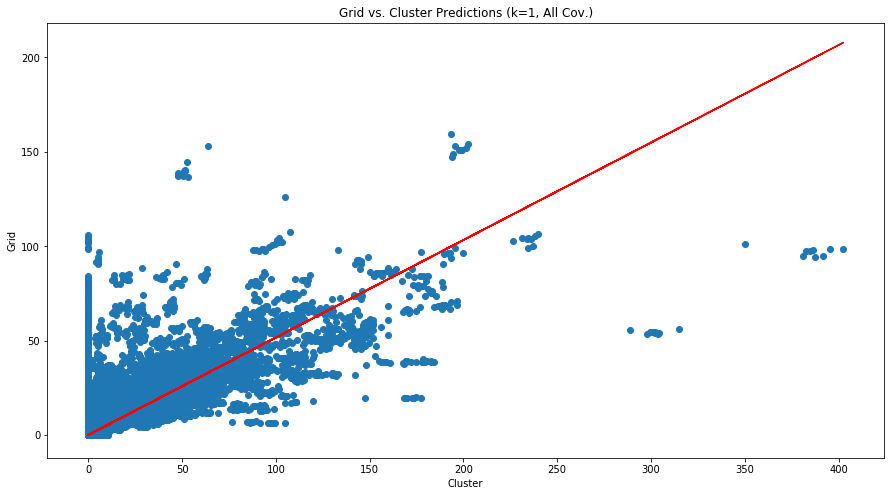

In [20]:
x = grid_vs_cluster_res['Cluster_All'][0][1].flatten()
y = grid_vs_cluster_res['Grid_All'][0][1].flatten()

fit = np.polyfit(x, y, deg=1)
_ = plt.plot(x, fit[0] * x + fit[1], color='red')
_ = plt.scatter(x, y)
plt.xlabel('Cluster')
plt.ylabel('Grid')
plt.title('Grid vs. Cluster Predictions (k=1, All Cov.)')
print fit

In [48]:
print np.mean(x), np.mean(y), np.mean(grid_vs_cluster_res['Cluster_All'][0][0].flatten()), np.mean(grid_vs_cluster_res['Grid_All'][0][0].flatten())

0.0426424292154 0.0382752221988 0.0468084147258 0.0468084147258


In [21]:
print np.mean(x), np.mean(y), np.mean(grid_vs_cluster_res['Cluster_All'][0][0].flatten()), np.mean(grid_vs_cluster_res['Grid_All'][0][0].flatten())

0.0435882794891 0.0395171550213 0.0468084147258 0.0468084147258


In [51]:
x = grid_vs_cluster_res['Cluster_All'][0][1].flatten()
y = grid_vs_cluster_res['Grid_All'][0][1].flatten()
print np.var(x), np.var(y), np.var(grid_vs_cluster_res['Cluster_All'][0][0].flatten()), np.var(grid_vs_cluster_res['Grid_All'][0][0].flatten())


1.91803879378 0.88527897639 2.46979745215 2.46979745215


In [23]:
np.shape(grid_vs_cluster_res['Cluster_All'])

(5, 2, 33, 55, 9900)

[  1.00000000e+00   4.52075142e-15]


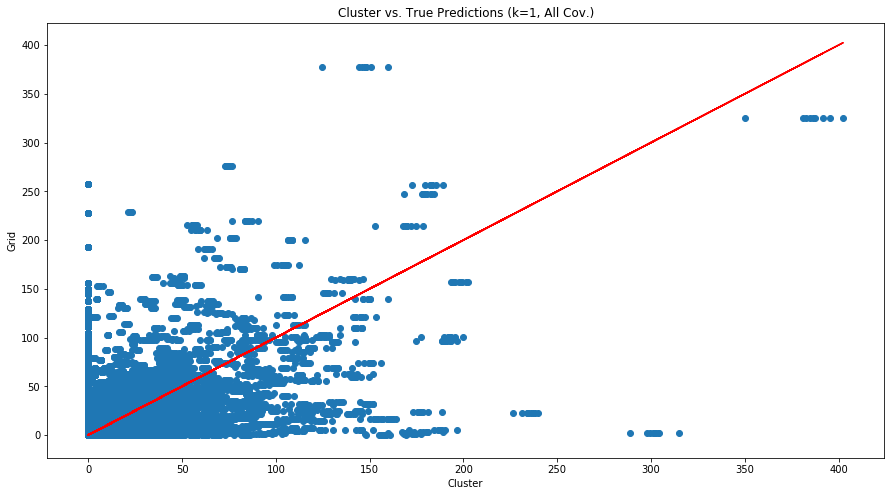

In [24]:
x = grid_vs_cluster_res['Cluster_All'][0][1].flatten()
y = grid_vs_cluster_res['Cluster_All'][0][0].flatten()

fit = np.polyfit(range(1,200), range(1,200), deg=1)
_ = plt.plot(x, fit[0] * x + fit[1], color='red')
_ = plt.scatter(x, y)
plt.xlabel('Cluster')
plt.ylabel('True')
plt.title('Cluster vs. True Predictions (k=1, All Cov.)')
print fit

[  1.00000000e+00   4.52075142e-15]


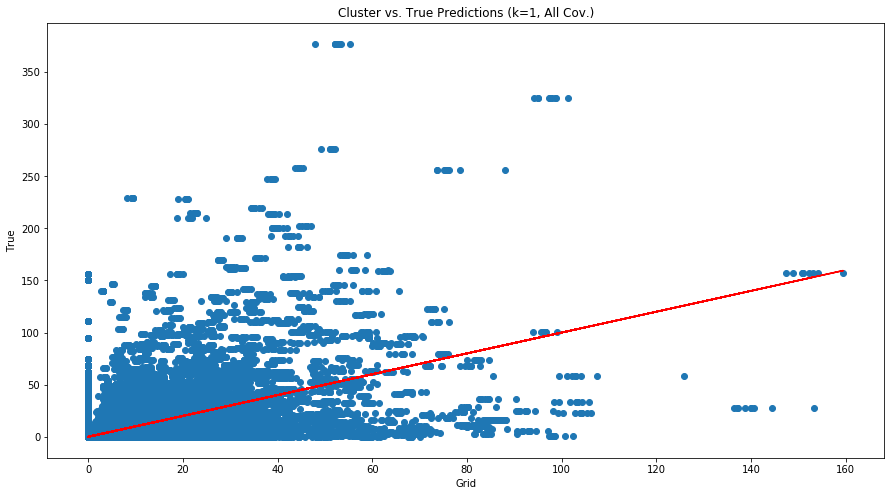

In [25]:
x = grid_vs_cluster_res['Grid_All'][0][1].flatten()
y = grid_vs_cluster_res['Grid_All'][0][0].flatten()

fit = np.polyfit(range(1,200), range(1,200), deg=1)
_ = plt.plot(x, fit[0] * x + fit[1], color='red')
_ = plt.scatter(x, y)
plt.xlabel('Grid')
plt.ylabel('True')
plt.title('Cluster vs. True Predictions (k=1, All Cov.)')
print fit